In [1]:
#imports
import numpy as np
import numpy.random as rd
import numpy.linalg as linalg
import math
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from hmmlearn import hmm

In [2]:
def sample(prob): # BS can be done
    r = rd.random();i = 0
    while r > prob[i]:
        r-=prob[i]
        i+=1
    return i

def bernoulli(prob):
    if rd.random() > prob:
        return 1
    return 0

def row_normalize(arr):
    arr = np.array(arr,float)
    for i in range(np.shape(arr)[0]):
        arr[i] = arr[i]/np.sum(arr[i])
    return arr

def dot(x,y):
    return np.sum(np.multiply(x,y))

In [123]:
en = 6
ch = 8
# P = np.array([.2,.4,.4])
# E = np.array([[.5,.6,.4],[.2,.3,.1],[.4,.5,.3]])
# E = np.array([[.6,.9,.3],[.3,.5,.1],[.4,.1,.05]])
# R = np.array([8.,6.,4.])
P = row_normalize([np.random.rand(ch)/2])[0]
E = np.random.rand(en,ch)/2
R = np.array([np.random.randint(1,10) for i in range(en)])
tol = .25
print(P)
# print(E)
print(R)

[0.14356751 0.08346905 0.00497119 0.09955387 0.14883873 0.16997665
 0.23645055 0.11317245]
[5 3 9 7 3 8]


In [124]:
ub = np.sum(E*P,axis=1)
ltemp = linprog(c = -1*R, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='simplex')
print(min(ub))
print(dot(ltemp.x,R), np.sum(ltemp.x),ltemp.con, ltemp.success, dot(ltemp.x,ub))
org_x = ltemp.x
print(ltemp.x)

0.1661029284962408
8.457825183515808 1.0 [0.] True 0.25
[0.         0.         0.45782518 0.         0.         0.54217482]


In [125]:
print(en,ch,tol,np.dot(ltemp.x,R),min(ub))
print(P)
print(E)
print(ltemp.x)

6 8 0.25 8.457825183515808 0.1661029284962408
[0.14356751 0.08346905 0.00497119 0.09955387 0.14883873 0.16997665
 0.23645055 0.11317245]
[[0.22172848 0.17118374 0.11168265 0.27730576 0.40690929 0.03207099
  0.20257445 0.41794491]
 [0.04862787 0.18339099 0.11484029 0.47838837 0.42573986 0.3593215
  0.46231468 0.45638811]
 [0.19421113 0.49023918 0.38220519 0.31872073 0.3875503  0.48481238
  0.32110862 0.27309262]
 [0.17797227 0.41205005 0.07521531 0.05886983 0.45587425 0.45192427
  0.06820562 0.13938074]
 [0.00877372 0.23207362 0.33402239 0.27721158 0.16017205 0.34563507
  0.32798277 0.27238057]
 [0.26784642 0.03786601 0.33892123 0.40555086 0.0052393  0.09320011
  0.21403154 0.13430581]]
[0.         0.         0.45782518 0.         0.         0.54217482]


In [126]:
# finding safe x0
ub = E.transpose();tol_arr = [tol]*ch
ltemp = linprog(c=np.zeros(en),A_ub = ub,b_ub=tol_arr,A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-3})
x0 = np.transpose(row_normalize([ltemp.x+(0.0)])) # noise to safe to avoid singular matrices, 1.0e-2 is working
norm_x0 = linalg.norm(x0)
e0 = x0/norm_x0 # safe vector
e0_trans = e0.transpose()
en0 = sample(x0.transpose()[0])
b0 = bernoulli(E[en0][sample(P)])
yt = (E[en0]*(1-b0))+((1-E[en0])*b0)
yt = row_normalize([np.exp(yt)]).transpose()
c0 = dot(x0,np.matmul(E,yt)) # safe cost
print(x0.flatten(),c0)

[0.18116011 0.         0.         0.38167063 0.         0.43716926] 0.20946151389981993


In [145]:
# parameters
reg = 0.1 # lambda > 0, regualarization param
conf = 0.1 # delta >= 0, <= 1, confidence prob -> with 1-del prob tolerance holds
alfa_c = 0.0 # >= 1, ellipse radii, best : 0.001
Sa = 1.;La = 1.;Ra = 1. # assumption parameters
R_sum = np.sum(R)
Rn_trans = R/R_sum
Rn = np.transpose([Rn_trans])
# x = [np.transpose(row_normalize([np.ones(en)]))]
x = [x0]
r = [dot(x[-1],Rn)];c = [c0]
b = []; enc = [];chnl = []
avg_rate = []

In [146]:
# algo
iop = np.identity(en) - (np.matmul(x0,x0.transpose())/pow(norm_x0,2.0))
sigopt = reg*iop; uopt = 0
for t in range(1,10000):
    enc.append(sample(x[-1].transpose()[0]))
    chnl.append(sample(P))
    b.append(bernoulli(E[enc[-1]][chnl[-1]]))
    yt = (E[enc[-1]]*(1-b[-1]))+((1-E[enc[-1]])*b[-1])
    yt = row_normalize([np.exp(yt)]).transpose()
    r.append(dot(x[-1],Rn))
    c.append(dot(x[-1],np.matmul(E,yt)))
    copt = c[-1] - (dot(x[-1],e0)/norm_x0)*c[0]
    xopt = x[-1] - (dot(x[-1],e0)*e0)
    sigopt += np.matmul(xopt,xopt.transpose())
    uopt += (copt*xopt)
    muopt = np.matmul(linalg.pinv(sigopt),uopt) # (inverse is blowing up, singular matrices) so did pseudo(SVD)
    ub = ((c[0]/norm_x0)*e0_trans)+muopt.transpose()+(dot(e0,muopt)*e0_trans)
    betat = Ra*math.sqrt(en*math.log10((1+(t-1)*La*La/reg)/conf))+math.sqrt(reg)*Sa # used log10
    val = alfa_c*betat*linalg.norm(x[-1])
    try:
        ltemp = linprog(c = -1*Rn_trans, A_ub = ub, b_ub = [tol-val],A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-2})
    except:
        print(t,'skipped')
        continue
    x.append(np.transpose([ltemp.x]))
    avg_rate.append(dot(x[-1],Rn)*R_sum)
    print(t,avg_rate[-1],ltemp.success)
# print(copt)
# print(xopt)
# print(sigopt)
# print(uopt)
# print(muopt)
# print(ub,betat)

1 9.0 True
2 8.026645667070158 True
3 8.445906172583511 True
4 8.434116249767458 True
5 8.416893468951265 True
6 8.406886415774396 True
7 8.408916915779423 True
8 8.394938749738506 True
9 8.398458658926584 True
10 8.395284745888267 True
11 8.392334644831584 True
12 8.395229122904185 True
13 8.39755269777628 True
14 8.395106646646504 True
15 8.388921788043199 True
16 8.391366941019486 True
17 8.389766532615653 True
18 8.391854146583011 True
19 8.393663650844406 True
20 8.392194692754689 True
21 8.393800171272991 True
22 8.392706589487215 True
23 8.391723492884674 True
24 8.390594376246728 True
25 8.392026063588954 True
26 8.388669899155191 True
27 8.387789723188309 True
28 8.389209324857339 True
29 8.390505714644629 True
30 8.391694237231274 True
31 8.388909549017692 True
32 8.390093970326506 True
33 8.39118890178043 True
34 8.390419251846339 True
35 8.391436313232981 True
36 8.392383640736982 True
37 8.391794571985486 True
38 8.392677293081766 True
39 8.391969537594058 True
40 8.392800

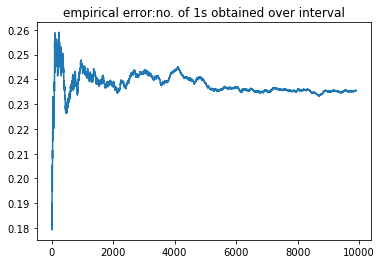

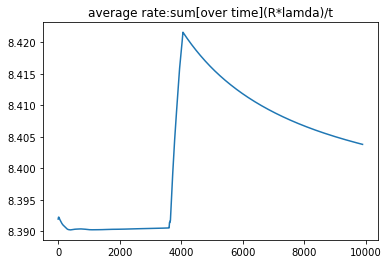

In [151]:
stat = 100
error_plot = 1.0 - np.copy(b)
for i in range(1,len(error_plot)):
    error_plot[i] += (error_plot[i-1]*(i-1))
    error_plot[i] =error_plot[i]/i
plt.plot(error_plot[stat:])
plt.title('empirical error:no. of 1s obtained over interval')
plt.show()
rate_plot = np.copy(avg_rate)
for i in range(1,len(rate_plot)):
    rate_plot[i] += (rate_plot[i-1]*(i-1))
    rate_plot[i] =rate_plot[i]/i
plt.plot(rate_plot[stat:])
plt.title('average rate:sum[over time](R*lamda)/t')
plt.show()

In [152]:
print(x[-1].flatten())
print(rate_plot[-1],error_plot[-1])
print(x[0].flatten())

[0.         0.         0.39123103 0.         0.         0.60876897]
8.403795084814824 0.23554710942188456
[0.18116011 0.         0.         0.38167063 0.         0.43716926]


3.844815150289918


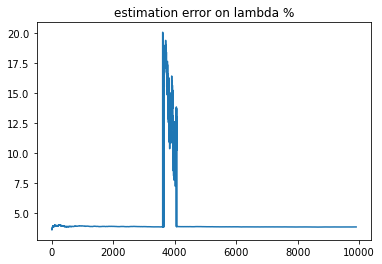

In [153]:
err = []
for i in x:
    err.append(np.sqrt(np.sum(np.square(org_x-i.flatten()))/en)*100)
print(err[-1])
plt.plot(err[stat:])
plt.title('estimation error on lambda %')
plt.show()

In [150]:
(Ra*math.sqrt(en*math.log10((1+(t-1)*La*La/.1)/0.9))+math.sqrt(.1)*Sa)*linalg.norm(x[-1]) 

4.210463114761602

In [ ]:
alfa_c -> lamda error %
0.0 -> 0.7263980978187543
0.0001 -> 0.64
0.001 -> 0.17
0.005 -> 4